In [65]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl
import pydot

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
image_size = (256, 256)
num_slices = 50

In [108]:
model = Sequential()
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True))
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True, go_backwards=True))
model.add(TimeDistributed(Conv2D(1, 1, activation='sigmoid')))
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_18 (ConvLSTM2D) (None, 50, 256, 256, 20)  15200     
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 50, 256, 256, 20)  28880     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 50, 256, 256, 1)   21        
Total params: 44,101
Trainable params: 44,101
Non-trainable params: 0
_________________________________________________________________


In [43]:
#from keras.utils import plot_model
#plot_model(model, to_file='lstm_model.png')

In [44]:
unet = load_model('unet.hdf5')
lstm = load_model('unet_lstm.hdf5')

In [98]:
X_unet = X.reshape((-1, *image_size, 1))
y_unet = y.reshape((-1, *image_size, 1))

In [99]:
# intermediate layer stuff
from keras.models import Model
int_layer_model = Model(input=unet.input, outputs=unet.layers[-2].output)

int_output = int_layer_model.predict(X_unet)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ba..., inputs=Tensor("in...)`
  


In [101]:
int_output.shape

(50, 256, 256, 64)

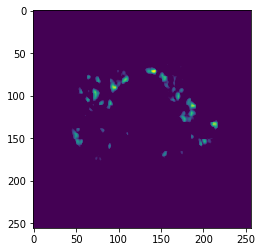

In [107]:
plt.imshow(int_output[30,:,:,14])

In [45]:
scans = pl.query(pl.Scan)
n = scans.count()

In [46]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [60]:
def get_data(i, only_nodules=True):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    start = np.random.randint(n - num_slices)
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    #y = np.expand_dims(y, axis=-1)
    return unet.predict(X, batch_size=1)[None], y[None]

In [48]:
num_epochs = 2
num_samples = 200

In [ ]:
for _ in range(num_samples):
    while True:
        i = np.random.choice(train)
        print(i)
        try:
            X, y = get_data(i)
            model.fit(X, y, batch_size=1, epochs=num_epochs)
            model.save('unet_lstm_bw.hdf5')
            break
        except OSError:
            print('Problem getting data')

157
Epoch 1/2
1/1 [==============================] - 7s 7s/step - loss: 0.6931 - acc: 0.8736
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.6870 - acc: 1.0000
645
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 0.6747 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.6503 - acc: 1.0000
942
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 0.5978 - acc: 0.9999
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.4995 - acc: 0.9999
176
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 0.3756 - acc: 0.9999
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.2609 - acc: 0.9999
585
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 0.1661 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 3s 3s/step - loss: 0.1041 - acc: 1.0000
316
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 0.0693 - acc: 1.00

In [ ]:
#model.save('unet_lstm.hdf5')

In [78]:
# evaluate lstm vs unet
ind = np.random.choice(test)
print(ind)
X, y = get_data(ind)
preds_unet = X
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())

preds_lstm = model.predict(preds_unet, batch_size=1)
fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())

141


In [21]:
# X_unet = X.reshape((-1, *image_size, 1))
# y_unet = y.reshape((-1, *image_size, 1))

0.40501148756298594
0.5603522223929729


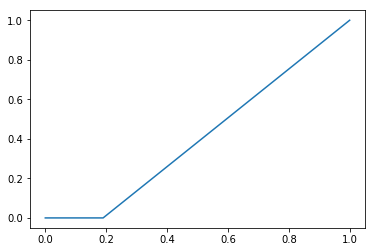

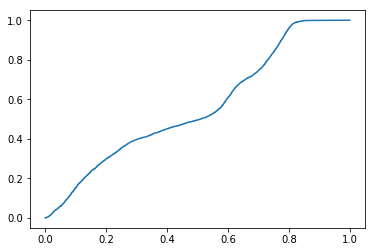

In [81]:
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

plt.plot(fpr_lstm, tpr_lstm)
plt.show()
plt.plot(fpr_unet, tpr_unet)
plt.show()

104
0.4051646972257328
0.9420030214643514


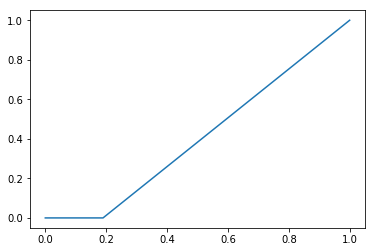

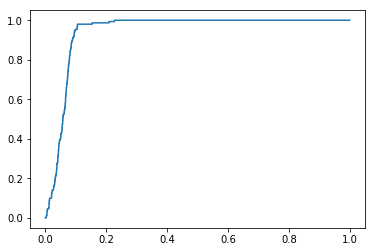

In [82]:
# evaluate lstm vs unet
ind = np.random.choice(test)
print(ind)
X, y = get_data(ind)
preds_unet = X
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())

preds_lstm = model.predict(preds_unet, batch_size=1)
fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())

print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

plt.plot(fpr_lstm, tpr_lstm)
plt.show()
plt.plot(fpr_unet, tpr_unet)
plt.show()

186
0.4051649287673382
0.8069561190212817


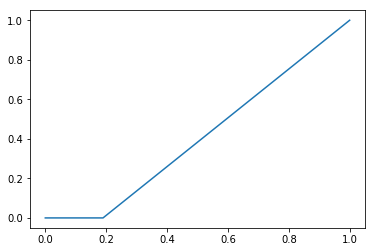

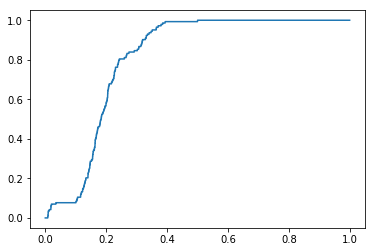

In [88]:
# evaluate lstm vs unet
ind = np.random.choice(test)
print(ind)
X, y = get_data(ind)
preds_unet = X
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())

preds_lstm = model.predict(preds_unet, batch_size=1)
fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())

print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

plt.plot(fpr_lstm, tpr_lstm)
plt.show()
plt.plot(fpr_unet, tpr_unet)
plt.show()

In [89]:
preds_lstm

array([[[[[0.409699  ],
          [0.3712146 ],
          [0.36049482],
          ...,
          [0.360497  ],
          [0.37227654],
          [0.41134652]],

         [[0.37016687],
          [0.30898035],
          [0.29227048],
          ...,
          [0.29227427],
          [0.31057215],
          [0.37219274]],

         [[0.3586619 ],
          [0.29122695],
          [0.2726422 ],
          ...,
          [0.27264714],
          [0.29266027],
          [0.3601337 ]],

         ...,

         [[0.35866016],
          [0.29122475],
          [0.27264047],
          ...,
          [0.27264783],
          [0.29266086],
          [0.36013404]],

         [[0.37049976],
          [0.3095698 ],
          [0.29274762],
          ...,
          [0.29275474],
          [0.31121013],
          [0.37258533]],

         [[0.40987274],
          [0.37116262],
          [0.35995862],
          ...,
          [0.35996345],
          [0.37240112],
          [0.41160092]]],


        [[[0.1181

In [75]:
tpr_unet

array([nan, nan, nan, ..., nan, nan, nan])

In [76]:
np.rint(y).flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [77]:
preds_lstm.flatten()

array([0.40970114, 0.37121758, 0.36049712, ..., 0.00108374, 0.00108374,
       0.00111505], dtype=float32)

In [23]:
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

0.9732168007531221
0.7169184511734369


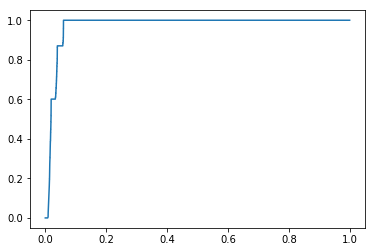

In [17]:
plt.plot(fpr, tpr)

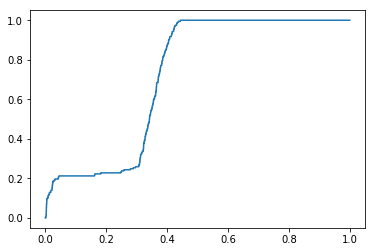

In [24]:
plt.plot(fpr_unet, tpr_unet)